In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/Users/purzelrakete/src/github.com/feldberlin/wavenet


In [2]:
import os

import numpy as np
import torch
import librosa
from torch.nn import functional as F
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from tqdm import tqdm

from wavenet import model, train, sample, audio, datasets, utils, viz

# Train on Tiny

A full training run with the big model, against tiny. Should absolutely crush it. 

In [3]:
dry = True 
if dry: os.environ['WANDB_MODE'] = 'disabled'

In [4]:
n, m = 30, 5_000
ds, ds_test = datasets.Tiny(n, m), datasets.Tiny(n, m)
X, Y = datasets.to_tensor(ds)

In [5]:
n_epochs = 15
batch_size = 24

In [6]:
def train(model, n_epochs):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.015, momentum=0.9)

    # training
    best_loss = np.Inf
    losses = []
    batches = list(zip(X.split(batch_size), Y.split(batch_size)))
    loader = tqdm((e, (it, b)) for e in range(n_epochs) for (it, b) in enumerate(batches))
    for epoch, (it, (x, y)) in loader:
        _, loss = model(x, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().numpy())
        
        if loss < best_loss:
            best_loss = loss
        if it % 9 == 0:
            loader.set_description(f'{epoch+1}:{it:03d} loss {loss.item():.5f} best loss {best_loss.item():.5f}')
            
    return losses

15:207 loss 0.58033 best loss 0.49292: : 3135it [04:43, 11.07it/s]


Text(0.5, 1.0, 'cross entropy. best: 0.4902147948741913')

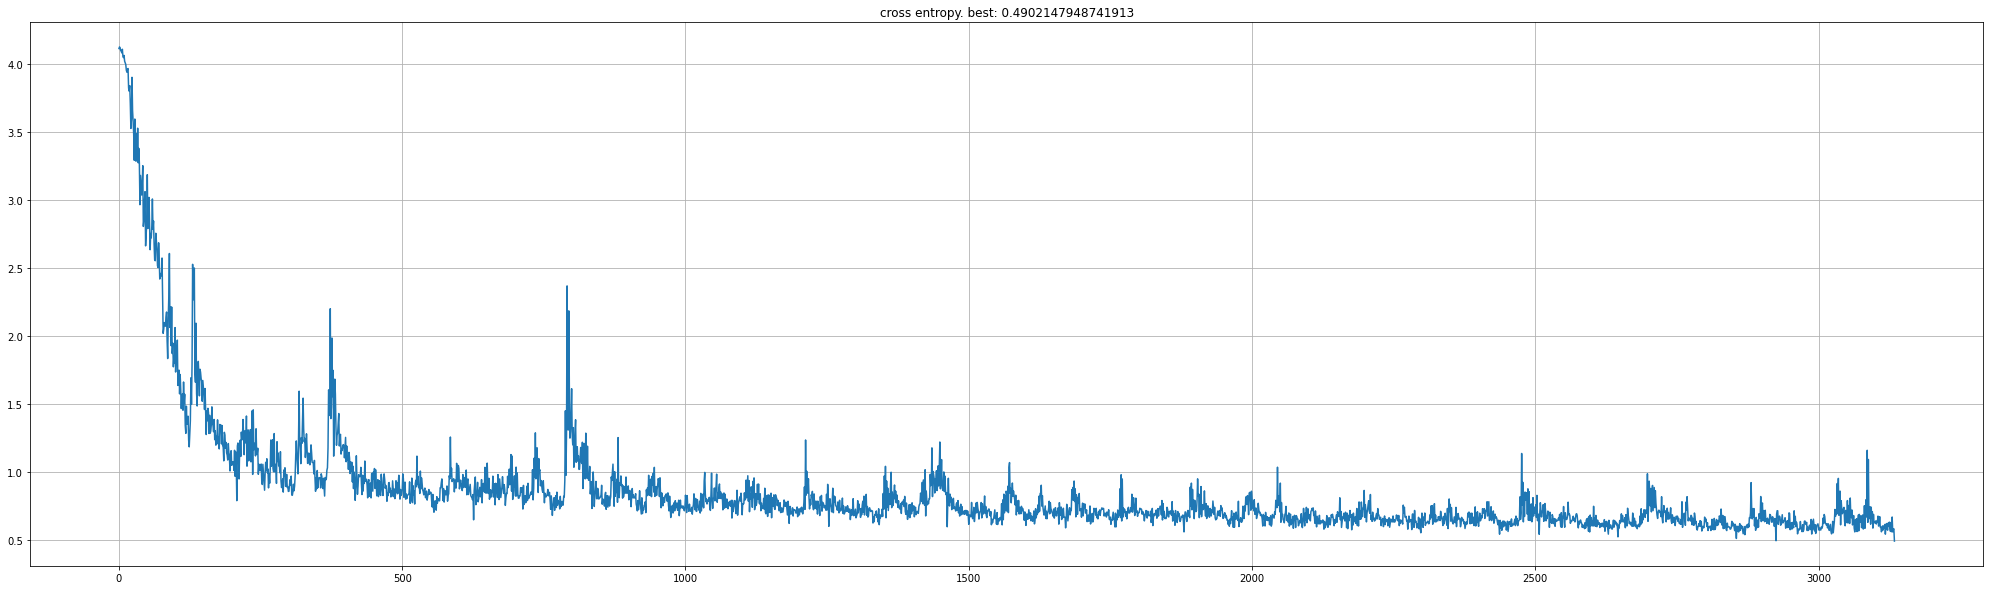

In [7]:
m = model.Wavenet(
    model.HParams(
        mixed_precision=False,
        n_audio_chans=1, 
        n_classes=2*n, 
        compress=False, 
        sample_length=n, 
        n_chans=32
    )
)

losses = train(m, n_epochs)

plt.figure(figsize=(35, 10))
plt.plot(losses)
plt.grid()
plt.title(f'cross entropy. best: {min(losses)}')

## Sample

In [11]:
def sample(model, n_samples = 48):
    generated = X.new_zeros((n_samples,) + X.size()[1:])
    flat = generated.view(generated.size(0), -1)

    # sampling
    for t in range(flat.size(1)):
        x = (generated.float() - ds.mean) / ds.std
        y, _ = model(x)
        logits = y[:, :, 0, t]
        dist = torch.distributions.categorical.Categorical(logits = y[:, :, 0, t])
        flat[:, t] = dist.sample()
        
    return generated

In [12]:
generated = sample(m)

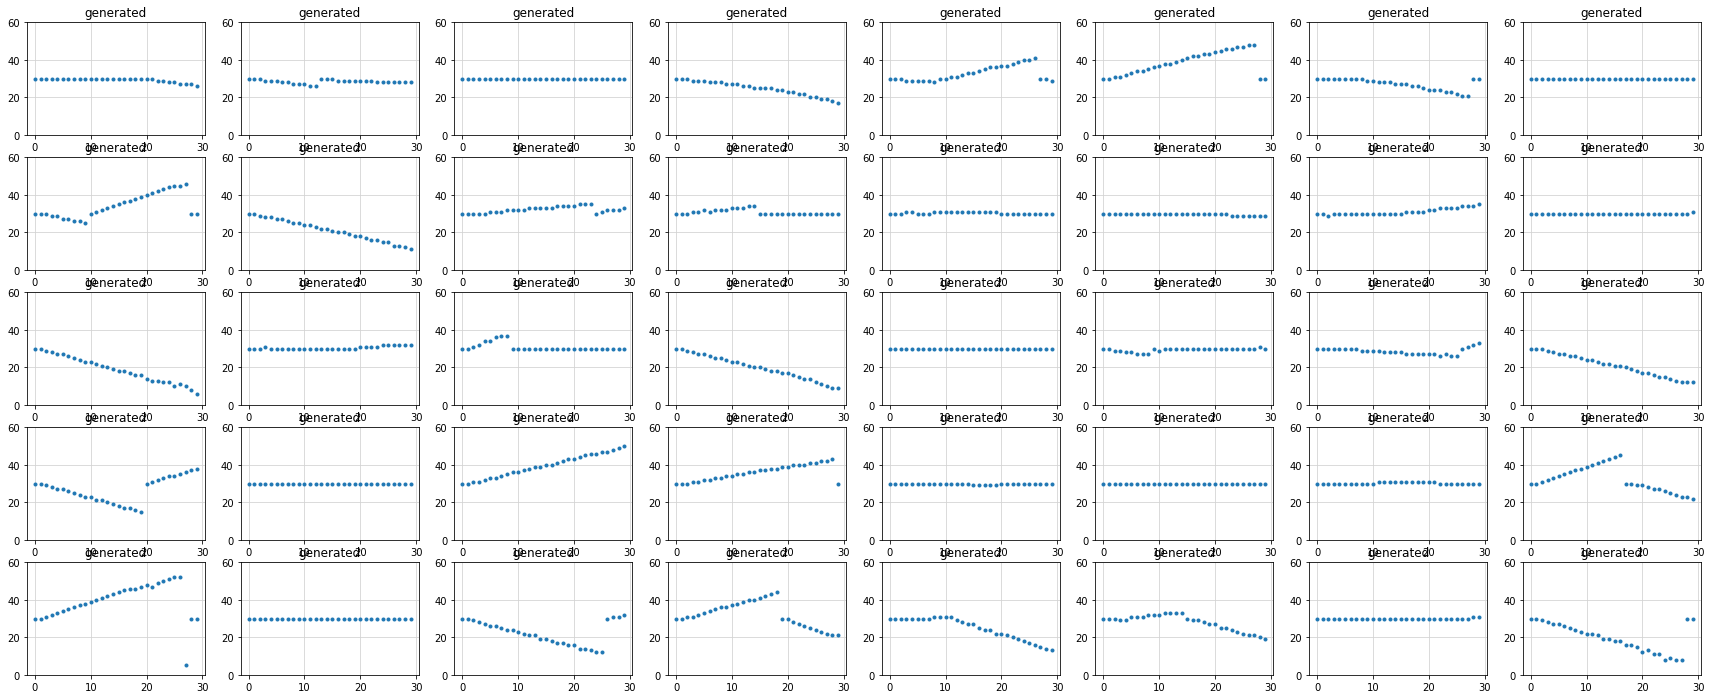

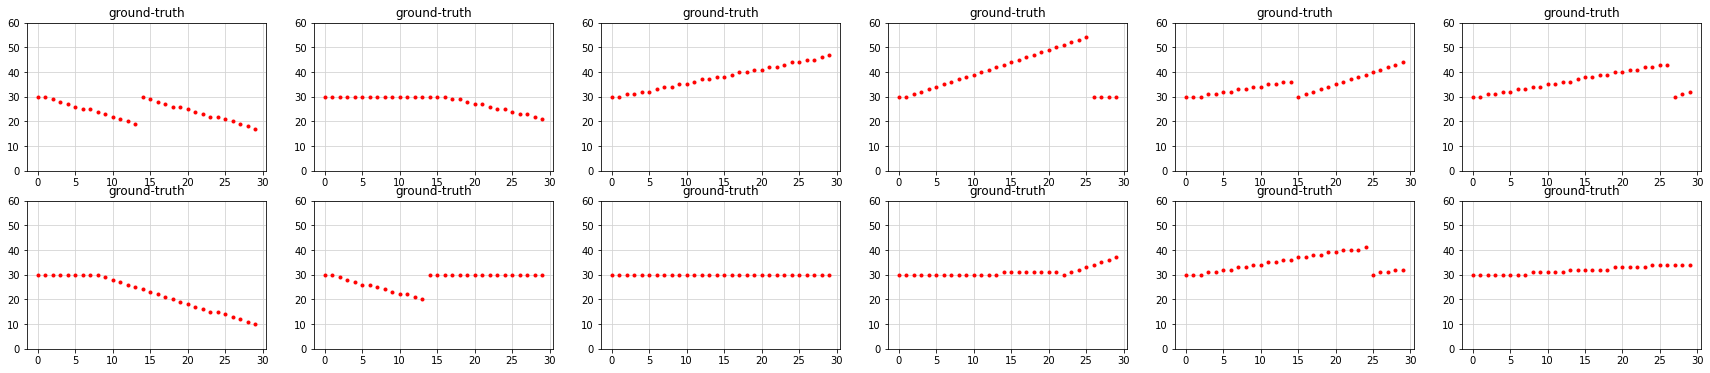

In [13]:
plt.subplots(figsize=(30, 12))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.ylim(0, 2*n)
    plt.grid(color='lightgray')
    plt.plot(torch.arange(n), generated[i, 0], '.')
    plt.title('generated')
    
plt.subplots(figsize=(30, 6))
for i in range(12):
    plt.subplot(2, 6, i+1)
    plt.ylim(0, 2*n)
    plt.grid(color='lightgray')
    plt.plot(torch.arange(n), Y[i].squeeze(), '.', color='red')
    plt.title('ground-truth')